In [103]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from collections import defaultdict
from itertools import product
from sklearn.metrics import mean_absolute_error as mae
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim

In [254]:
# look_back = 504
look_back = 72 * 3
batch_size = 512

In [2]:
dat = pd.read_csv('train.csv', index_col='row_id')
dat.head(10)

,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01 00:00:00,0,0,EB,70
1,1991-04-01 00:00:00,0,0,NB,49
2,1991-04-01 00:00:00,0,0,SB,24
3,1991-04-01 00:00:00,0,1,EB,18
4,1991-04-01 00:00:00,0,1,NB,60
5,1991-04-01 00:00:00,0,1,SB,58
6,1991-04-01 00:00:00,0,1,WB,26
7,1991-04-01 00:00:00,0,2,EB,31
8,1991-04-01 00:00:00,0,2,NB,49


In [3]:
def preprocess(dat):
    time_mapper = {}
    ii = 0
    for h in range(24):
        for mm in ['00','20','40']:
            hh = '{0:02d}'.format(h)
            time_mapper[hh+':'+mm] = ii
            ii += 1

    dat['unique'] = dat['x'].astype(str) + dat['y'].astype(str) + dat['direction']
    uniques = dat['unique'].unique()
    dat['day'] = pd.to_datetime(dat['time']).dt.weekday
    dat['time_stamp'] = dat['time'].apply(lambda x:time_mapper[x.split()[1][:5]])

    tmp = dat.groupby(['unique','day','time_stamp']).agg({'congestion':np.median})
    median_mapper = tmp.to_dict()['congestion']
    dat['median'] = dat.apply(lambda x: \
                              median_mapper[x['unique'],x['day'],x['time_stamp']], axis=1)
    dat['congestion-median'] = dat['congestion'] - dat['median']
    
    all_time = pd.DataFrame(pd.date_range('1991-04-01 00:00:00', '1991-09-30 11:40:00', freq='20Min'), columns=['time'])
    all_time['time'] = all_time['time'].astype(str)
    
    return uniques, median_mapper, time_mapper, all_time

In [5]:
uniques, median_mapper, time_mapper, all_time = preprocess(dat)

In [6]:
dat

,time,x,y,direction,congestion,unique,day,time_stamp,median,congestion-median
row_id,,,,,,,,,,
0,1991-04-01 00:00:00,0,0,EB,70,00EB,0,0,35.0,35.0
1,1991-04-01 00:00:00,0,0,NB,49,00NB,0,0,29.0,20.0
2,1991-04-01 00:00:00,0,0,SB,24,00SB,0,0,24.0,0.0
3,1991-04-01 00:00:00,0,1,EB,18,01EB,0,0,17.0,1.0
4,1991-04-01 00:00:00,0,1,NB,60,01NB,0,0,63.0,-3.0
...,...,...,...,...,...,...,...,...,...,...
848830,1991-09-30 11:40:00,2,3,NB,54,23NB,0,35,58.0,-4.0
848831,1991-09-30 11:40:00,2,3,NE,28,23NE,0,35,26.0,2.0
848832,1991-09-30 11:40:00,2,3,SB,68,23SB,0,35,71.0,-3.0


In [44]:
from sklearn.preprocessing import StandardScaler

In [71]:
def getseries(unique):
    df = dat.loc[dat['unique']==unique, ['time', 'congestion-median']]
    df = pd.merge(all_time, df, left_on='time', right_on='time', how='outer')
    df = df.set_index('time')
    df['congestion-median'] = df['congestion-median'].fillna(0)
    ss = StandardScaler()
    df['congestion-median-normalized'] = ss.fit_transform(df['congestion-median'].values.reshape(-1,1)).reshape(-1)
    return df, ss

In [72]:
df, ss = getseries('00EB')
print(ss.mean_, ss.scale_)
df

[0.95494673] [11.57954203]


,congestion-median,congestion-median-normalized
time,,
1991-04-01 00:00:00,35.0,2.940104
1991-04-01 00:20:00,35.0,2.940104
1991-04-01 00:40:00,35.0,2.940104
1991-04-01 01:00:00,35.0,2.940104
1991-04-01 01:20:00,35.0,2.940104
...,...,...
1991-09-30 10:20:00,-7.0,-0.686983
1991-09-30 10:40:00,-6.0,-0.600624
1991-09-30 11:00:00,-7.0,-0.686983


In [73]:
from matplotlib import pyplot as plt

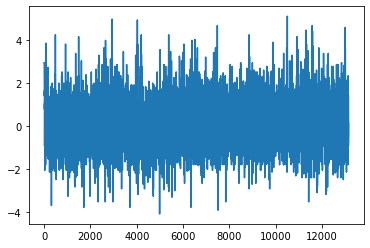

In [74]:
plt.plot(df['congestion-median-normalized'].values)

In [255]:
test_periods = [
    ['1991-08-26 12:00:00', '1991-09-02 24:00:00'],
    ['1991-09-02 12:00:00', '1991-09-02 24:00:00'],
    ['1991-09-09 12:00:00', '1991-09-09 24:00:00'],
    ['1991-09-16 12:00:00', '1991-09-16 24:00:00']]

In [256]:
test_periods_with_lookback = []
for period in test_periods:
    id1 = df.index.to_list().index(period[0])
    test_periods_with_lookback.append([df.index[id1-look_back], period[1]])
test_periods_with_lookback

[['1991-08-23 12:00:00', '1991-09-02 24:00:00'],
 ['1991-08-30 12:00:00', '1991-09-02 24:00:00'],
 ['1991-09-06 12:00:00', '1991-09-09 24:00:00'],
 ['1991-09-13 12:00:00', '1991-09-16 24:00:00']]

In [143]:
df.loc['1991-08-25 12:00:00']

congestion-median              -6.000000
congestion-median-normalized   -0.600624
Name: 1991-08-25 12:00:00, dtype: float64

In [144]:
df.loc['1991-08-26 12:00:00']

congestion-median               10.000000
congestion-median-normalized     0.781124
Name: 1991-08-26 12:00:00, dtype: float64

In [241]:
def create_dataset(dataset, look_back=5):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+1:i+look_back+1])
    return np.array(dataX), np.array(dataY)

In [242]:
def assemble(dat):
    train_loaders, test_loaders = [], []
    for period in test_periods_with_lookback:
        train = dat.loc[dat.index < period[0], 'congestion-median-normalized'].values
        test = dat.loc[(dat.index >= period[0]) & (dat.index <= period[1]), 'congestion-median-normalized'].values
        print(test[0])
        
        X, y = create_dataset(train, look_back=look_back)
        train_dataset = []
        for i in range(len(X)):
            train_dataset.append((torch.tensor(X[i].reshape(-1,1),dtype=torch.float32),
                                  torch.tensor(y[i].reshape(-1,1),dtype=torch.float32)))
        train_loaders.append(DataLoader(train_dataset, batch_size=batch_size, drop_last=False))
        
        X, y = create_dataset(test, look_back=look_back)
        test_dataset = []
        for i in range(len(X)):
            test_dataset.append((torch.tensor(X[i].reshape(-1,1),dtype=torch.float32),
                                 torch.tensor(y[i].reshape(-1,1),dtype=torch.float32)))
        test_loaders.append(DataLoader(test_dataset, batch_size=batch_size, drop_last=False))
        
    return train_loaders, test_loaders

In [257]:
train_loaders, test_loaders = assemble(df)

-0.3415460401661718
1.3856379837652852
-1.3778564545250458
2.0765115933378677


In [258]:
next(iter(test_loaders[0]))[0].shape,next(iter(test_loaders[0]))[1].shape

(torch.Size([512, 216, 1]), torch.Size([512, 216, 1]))

In [259]:
class MyModel(nn.Module):
    def __init__(self, input_feature, hidden_size, output_feature, num_layers=1):
        super(MyModel, self).__init__()
        self.linear = nn.Linear(input_feature, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=num_layers, dropout=0.2)
        ''' gru input is (N,L,H_in=H_hidden), output is (N,L,H_hidden), hidden is (num_layers, h_hidden)'''
        self.linear_out = nn.Linear(hidden_size, output_feature)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
    
    def forward(self, input, hidden):
        ''' X is in the shape of (N,L,input_feature) '''
        output = F.relu(self.linear(input))
        output, hidden = self.gru(output, hidden)
        output = self.linear_out(F.relu(output))
        return output
    
    def initHidden(self, batch_size):
        return torch.zeros((self.num_layers, batch_size, self.hidden_size))

In [260]:
model = MyModel(1, 4, 1, num_layers=3)
criterion = nn.L1Loss()

In [261]:
xtmp = next(iter(train_loaders[0]))
xtmp[0].shape

torch.Size([512, 216, 1])

In [262]:
h0 = model.initHidden(len(xtmp[0]))
h0.shape

torch.Size([3, 512, 4])

In [263]:
y_pred = model.forward(xtmp[0], h0)
y_pred.shape

torch.Size([512, 216, 1])

In [264]:
next(iter(train_loaders[0]))[1].shape

torch.Size([512, 216, 1])

In [265]:
criterion(y_pred, next(iter(train_loaders[0]))[1])

tensor(0.6612, grad_fn=<L1LossBackward0>)

In [266]:
def evaluate(test_loader):
    model.eval()
    with torch.no_grad():
        loss = 0
        n = 0
        for batch, (x, y) in enumerate(test_loader):
            h0 = model.initHidden(len(x))
            output = model.forward(x, h0)
            loss += criterion(output ,y).item() * len(x)
            n += len(x)
        loss /= n
    return loss

def train(n_epoches, train_loader, test_loader):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    for epoch in range(n_epoches):
        
        curr_loss = 0.0
        model.train()
        
        n = 0
        for batch, (x, y) in enumerate(train_loader):
            h0 = model.initHidden(len(x))
            output = model.forward(x, h0)
            loss = criterion(output, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            curr_loss += loss*len(x)
            n += len(x)
        
        curr_loss /= len(train_loader.dataset)
        test_loss = evaluate(test_loader)
        print(f'current training loss={loss.item()} test loss = {test_loss}')


In [267]:
train(100, train_loaders[-1], test_loaders[-1])

current training loss=0.961962103843689 test loss = 0.7813981771469116
current training loss=0.9586765766143799 test loss = 0.7762427926063538
current training loss=0.9555635452270508 test loss = 0.7717596888542175
current training loss=0.953068196773529 test loss = 0.7679600119590759
current training loss=0.9509341716766357 test loss = 0.7646756768226624
current training loss=0.9491881728172302 test loss = 0.7619644403457642
current training loss=0.9478358626365662 test loss = 0.7599841356277466
current training loss=0.9465978145599365 test loss = 0.7582958936691284
current training loss=0.9453668594360352 test loss = 0.7568888068199158
current training loss=0.9444662928581238 test loss = 0.7557480931282043
current training loss=0.943646252155304 test loss = 0.7548151612281799
current training loss=0.9427403211593628 test loss = 0.7540326714515686
current training loss=0.9419576525688171 test loss = 0.7533345222473145
current training loss=0.9412542581558228 test loss = 0.752566039562

In [222]:
0.786 * ss.scale_

array([9.10152004])

In [268]:
0.705 * ss.scale_

array([8.16357713])

In [270]:
X, Y = next(iter(train_loaders[0]))

In [273]:
h0 = model.initHidden(len(X))
Y_pred = model.forward(X,h0)

In [276]:
Y.reshape(len(Y),-1)

tensor([[ 2.9401,  2.9401,  2.9401,  ...,  0.1334,  0.1334,  0.1334],
        [ 2.9401,  2.9401,  2.9401,  ...,  0.1334,  0.1334,  0.0039],
        [ 2.9401,  2.9401,  2.2492,  ...,  0.1334,  0.0039,  0.0039],
        ...,
        [-0.6006, -0.6006, -0.6006,  ..., -0.6006, -0.8165, -0.9461],
        [-0.6006, -0.6006, -0.6006,  ..., -0.8165, -0.9461,  0.4789],
        [-0.6006, -0.6006, -0.6006,  ..., -0.9461,  0.4789,  0.4789]])

In [275]:
Y_pred.reshape(len(Y),-1)

tensor([[-0.1478, -0.1410, -0.1410,  ..., -0.1904, -0.1890, -0.1831],
        [-0.1478, -0.1410, -0.1410,  ..., -0.1890, -0.1831, -0.1756],
        [-0.1478, -0.1410, -0.1410,  ..., -0.1831, -0.1756, -0.1712],
        ...,
        [-0.1919, -0.2021, -0.1989,  ..., -0.1912, -0.1917, -0.1964],
        [-0.1896, -0.1974, -0.1933,  ..., -0.1917, -0.1964, -0.2064],
        [-0.1896, -0.1974, -0.1933,  ..., -0.1964, -0.2064, -0.2005]],
       grad_fn=<ReshapeAliasBackward0>)

In [277]:
criterion(Y_pred, Y)

tensor(0.6539, grad_fn=<L1LossBackward0>)

In [278]:
nn.L1Loss?